# First Part : Text Extraction Using google-play-scraper  




## Installing Dependencies 

In [1]:
# Google provides APIs to easily crawl the PlayStore for Python 
# without any external dependencies 
!pip install -qq google-play-scraper

     |████████████████████████████████| 52 kB 992 kB/s 


In [2]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

# Pygments is a syntax highlighting package suitable for code hosting, forums
from pygments import highlight
# JsonLexer for parsing JSOn files
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [3]:
app_packages = [
  'com.anydo',
  'com.todoist',      
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

## Usage of the google-play-scraper
 - 通過將 JSON 物件轉換為 Pandas 數據並將結果保存到 CSV 文件來儲存應用程式資訊以備後續情感分析使用：

In [4]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):       
  # To iterate over ratings 1 to 5 seperately.
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:   
    # Sort the most relevant and newest.
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,        
        # Get 200 3 rated reviews and 100 each of others.
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest' # Store the sort order.
        r['appId'] = ap  # Store the app id.
      app_reviews.extend(rvs)  # Extend the reviws to contain information about sort order and app id

100%|██████████| 15/15 [00:43<00:00,  2.89s/it]


In [6]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str         
    # Some date time and other formats are also converted into string while printing
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))  
  # Terminal formatter to highlight the different objects

In [7]:
# Sample review
print_json(app_reviews[0]) 
# Contains replies from the creators which is not so very useful.

{
  "appId": "com.anydo",
  "at": "2021-09-10 11:39:25",
  "content": "I have been using this app for 2 years and had premium for a year of that, and now I have a new phone I am trying to log in. Because my any.do is linked to my Facebook account, I click \"Use Facebook to log in\" but then it says Facebook login is disabled from this embedded browser. So I cannot login or use my account now.",
  "repliedAt": "2021-09-12 13:34:01",
  "replyContent": "We're sorry to hear you're experiencing issues with your app. Please reach out to our Support Team, at- www.any.do/contact_form, mentioning the app version you are currently using, and we will be more than happy to advise accordingly, and make sure you are able to use the app properly! :)\n",
  "reviewCreatedVersion": "5.15.1.6",
  "reviewId": "gp:AOqpTOHMGLwtbZHRkwU82NPaIwZNKkyg1A8H2byVsPuAN673Eu6JncFFnKKzIKG4USB6EIVX80YPsX0AAs5Flw",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.google

In [8]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

In [9]:
len(app_reviews_df)

16798

In [10]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHMGLwtbZHRkwU82NPaIwZNKkyg1A8H2byVsPu...,Kristina Downs,https://play-lh.googleusercontent.com/a-/AOh14...,I have been using this app for 2 years and had...,1,0,5.15.1.6,2021-09-10 11:39:25,We're sorry to hear you're experiencing issues...,2021-09-12 13:34:01,most_relevant,com.anydo
1,gp:AOqpTOGw0jBJ0bdj9A9rfU0K94KztVF1LbPm4J3OMoM...,Almighty Dodorex,https://play-lh.googleusercontent.com/a-/AOh14...,I have adhd and wanted to try this app out to ...,1,3,5.15.1.6,2021-09-01 06:20:25,The Recurring tasks are available for Free to ...,2021-09-06 06:03:37,most_relevant,com.anydo
2,gp:AOqpTOGVwGHta-LmxGR-XCkAgoV0UsiXa9TdPRzSmqe...,Ahmed Hassan,https://play-lh.googleusercontent.com/a/AATXAJ...,Not even recurring tasks are available in free...,1,1,5.15.1.6,2021-09-21 10:31:55,The Recurring Reminders feature is free for al...,2021-09-23 09:01:09,most_relevant,com.anydo
3,gp:AOqpTOE_g-6xnCYUjPLtxAbUG3w24GRydoSailWnevV...,Jiacheng Lane,https://play-lh.googleusercontent.com/a-/AOh14...,Review got removed 2 times. Heads up here you ...,1,0,5.15.1.6,2021-09-26 05:14:25,We do not remove reviews. Like many other apps...,2021-09-26 16:30:17,most_relevant,com.anydo
4,gp:AOqpTOEQEKUS7I0TtYqIUH03SWukr2WR51nrAd5uhdl...,Hirak Hax,https://play-lh.googleusercontent.com/a/AATXAJ...,Basic features. Whatsapp integration is useles...,1,4,5.15.1.6,2021-09-01 03:30:31,"Hi, we're sorry to hear you're experiencing is...",2021-09-05 15:23:54,most_relevant,com.anydo


# Second Part : Sentiment Analy Using Bert


## Installing Dependencies

In [11]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 3.3 MB 22.9 MB/s 
     |████████████████████████████████| 636 kB 54.9 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Read the Data

In [13]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHMGLwtbZHRkwU82NPaIwZNKkyg1A8H2byVsPu...,Kristina Downs,https://play-lh.googleusercontent.com/a-/AOh14...,I have been using this app for 2 years and had...,1,0,5.15.1.6,2021-09-10 11:39:25,We're sorry to hear you're experiencing issues...,2021-09-12 13:34:01,most_relevant,com.anydo
1,gp:AOqpTOGw0jBJ0bdj9A9rfU0K94KztVF1LbPm4J3OMoM...,Almighty Dodorex,https://play-lh.googleusercontent.com/a-/AOh14...,I have adhd and wanted to try this app out to ...,1,3,5.15.1.6,2021-09-01 06:20:25,The Recurring tasks are available for Free to ...,2021-09-06 06:03:37,most_relevant,com.anydo
2,gp:AOqpTOGVwGHta-LmxGR-XCkAgoV0UsiXa9TdPRzSmqe...,Ahmed Hassan,https://play-lh.googleusercontent.com/a/AATXAJ...,Not even recurring tasks are available in free...,1,1,5.15.1.6,2021-09-21 10:31:55,The Recurring Reminders feature is free for al...,2021-09-23 09:01:09,most_relevant,com.anydo
3,gp:AOqpTOE_g-6xnCYUjPLtxAbUG3w24GRydoSailWnevV...,Jiacheng Lane,https://play-lh.googleusercontent.com/a-/AOh14...,Review got removed 2 times. Heads up here you ...,1,0,5.15.1.6,2021-09-26 05:14:25,We do not remove reviews. Like many other apps...,2021-09-26 16:30:17,most_relevant,com.anydo
4,gp:AOqpTOEQEKUS7I0TtYqIUH03SWukr2WR51nrAd5uhdl...,Hirak Hax,https://play-lh.googleusercontent.com/a/AATXAJ...,Basic features. Whatsapp integration is useles...,1,4,5.15.1.6,2021-09-01 03:30:31,"Hi, we're sorry to hear you're experiencing is...",2021-09-05 15:23:54,most_relevant,com.anydo


In [14]:
df.shape

(16798, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16798 entries, 0 to 16797
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16798 non-null  object
 1   userName              16796 non-null  object
 2   userImage             16798 non-null  object
 3   content               16798 non-null  object
 4   score                 16798 non-null  int64 
 5   thumbsUpCount         16798 non-null  int64 
 6   reviewCreatedVersion  14254 non-null  object
 7   at                    16798 non-null  object
 8   replyContent          9082 non-null   object
 9   repliedAt             9082 non-null   object
 10  sortOrder             16798 non-null  object
 11  appId                 16798 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


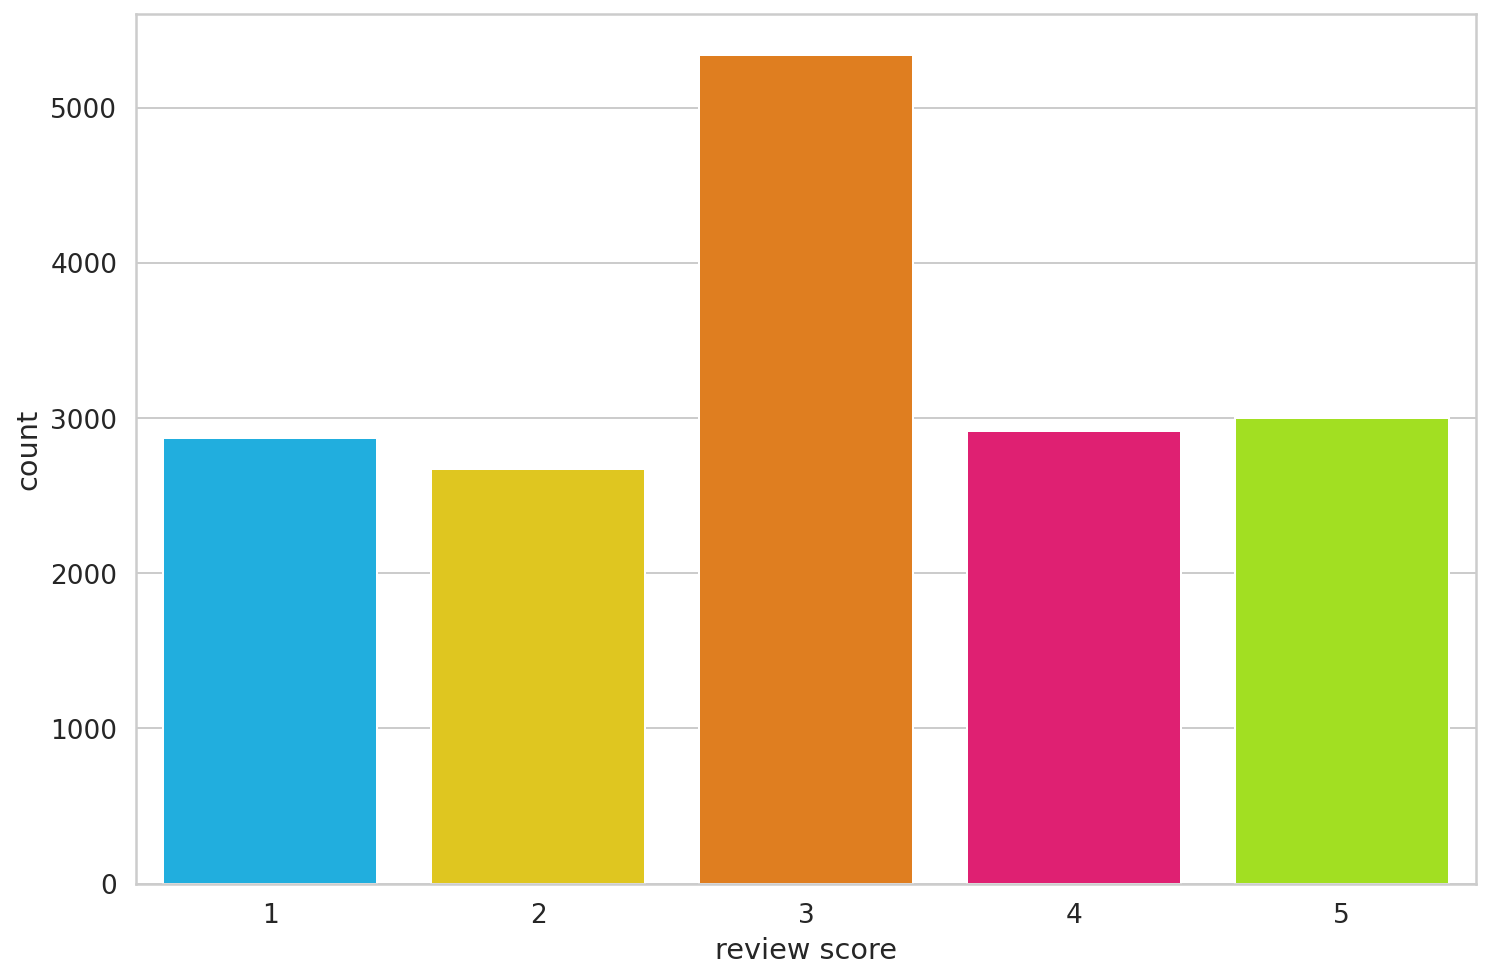

In [16]:
sns.countplot(df.score)
plt.xlabel('review score');

我們有一個關於評論的平衡數據集（經過之前的處理，使評論保持平衡）

In [17]:
def group_sentiment(rating):
  #rating = int(rating)
  if rating <= 2:
    return 0         # Negetive sentiment
  elif rating == 3:
    return 1         # Neutral Sentiment
  else: 
    return 2         # positive Sentiment

df['sentiment'] = df.score.apply(group_sentiment)

In [18]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


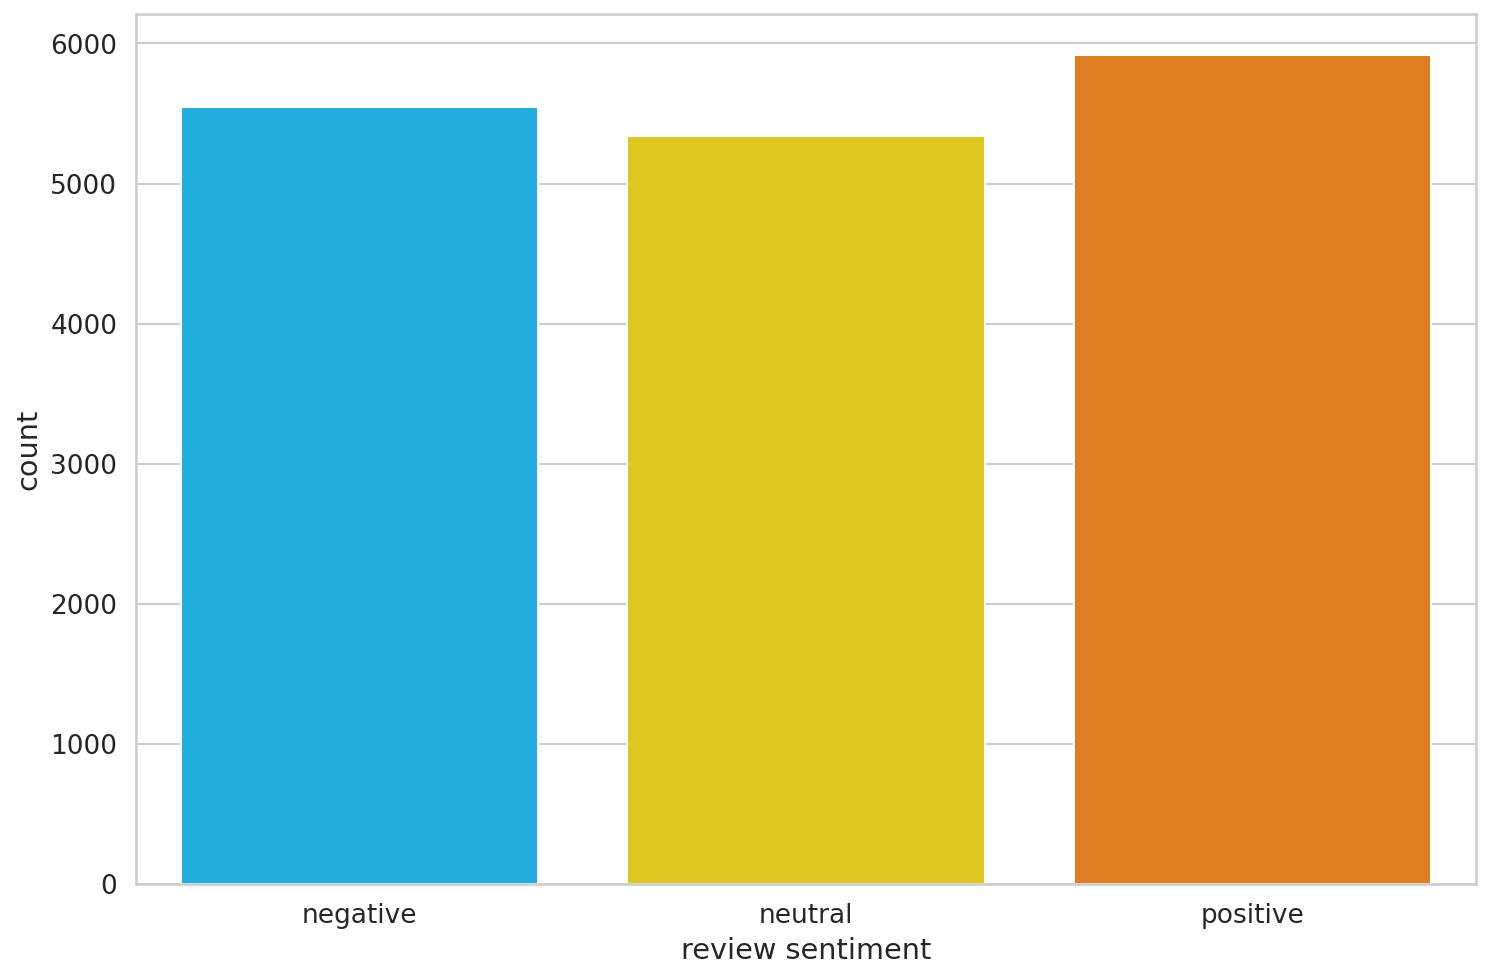

In [19]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Data Preprocessing
機器學習模型不適用於原始文本。我們需要將文本轉換為數字（某種形式）。 BERT 需要比較特別的處理。以下是要求：

* 添加特殊標記來分隔句子並進行分類
* 傳遞固定長度的序列（引入 padding ）
* 創建稱為 attention mask 的 0（pad token）和 1（real token）數組

Transformers 庫提供了多種 Transformer 模型（包括 BERT）。它還包括預構建的標記器，可以解決預處理所需的大部分

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

load a pre-trained BertTokenizer:


In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


表示句子之間分隔的特殊標記的要求由 Huggingface 提供的 tokenizer 負責。 BERT 接受過問答任務的訓練，但我使用它來訓練一系列句子作為輸入。我需要等長的序列，這是通過 zero padding 標記而不失一般性到句子末尾來完成的。

我們還需要傳遞attention mask，它基本上將值 1 傳遞給所有有意義的標記，將 0 傳遞給填充標記

### 下面將使用簡單的句子來理解標記化過程：

In [22]:
sample_txt = 'Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.'
#sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [23]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Sentence: {sample_txt}')
print(f'\n  Tokens: {tokens}')
print(f'\n  Token IDs: {token_ids}')   # Each token has a an unique ID for the model to unserstand what we are referring to.

  Sentence: Best place that I have visited? Iceland was the most beautiful and I consider myself lucky to have visited Iceland at such an early age.

  Tokens: ['Best', 'place', 'that', 'I', 'have', 'visited', '?', 'Iceland', 'was', 'the', 'most', 'beautiful', 'and', 'I', 'consider', 'myself', 'lucky', 'to', 'have', 'visited', 'Iceland', 'at', 'such', 'an', 'early', 'age', '.']

  Token IDs: [1798, 1282, 1115, 146, 1138, 3891, 136, 10271, 1108, 1103, 1211, 2712, 1105, 146, 4615, 1991, 6918, 1106, 1138, 3891, 10271, 1120, 1216, 1126, 1346, 1425, 119]


In [24]:
len(tokens)

27

#### Special Tokens
 - [SEP] - 一個句子的結尾標記
 - [CLS] - 我們必須將此標記添加到每個句子的開頭，以便 BERT 知道我們在進行分類
 - [PAD] - 填充的標記
 - [UNK] - 沒看過的 token 都用此代替

In [25]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [26]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [27]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [28]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### 以上所有工作都可以使用 encode_plus() 方法完成

In [29]:
encoding_test = tokenizer.encode_plus(
  sample_txt,
  max_length=32,           # sequence length
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors(use tf for tensorflow and keras)
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
encoding_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [31]:
print(' length of the first sequence is :  ', len(encoding_test['input_ids'][0]))
print('\n The input id\'s are : \n', encoding_test['input_ids'][0])
print('\n The attention mask generated is : ', encoding_test['attention_mask'][0])

 length of the first sequence is :   32

 The input id's are : 
 tensor([  101,  1798,  1282,  1115,   146,  1138,  3891,   136, 10271,  1108,
         1103,  1211,  2712,  1105,   146,  4615,  1991,  6918,  1106,  1138,
         3891, 10271,  1120,  1216,  1126,  1346,  1425,   119,   102,     0,
            0,     0])

 The attention mask generated is :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0])


反轉標記化以查看特殊標記 : 

In [32]:
tokenizer.convert_ids_to_tokens(encoding_test['input_ids'].flatten())

['[CLS]',
 'Best',
 'place',
 'that',
 'I',
 'have',
 'visited',
 '?',
 'Iceland',
 'was',
 'the',
 'most',
 'beautiful',
 'and',
 'I',
 'consider',
 'myself',
 'lucky',
 'to',
 'have',
 'visited',
 'Iceland',
 'at',
 'such',
 'an',
 'early',
 'age',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### 選擇序列長度

檢查內容列中是否有任何nan

In [33]:
df.loc[df.content.isnull()]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment


In [34]:
df = df[df['content'].notna()]
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOHMGLwtbZHRkwU82NPaIwZNKkyg1A8H2byVsPu...,Kristina Downs,https://play-lh.googleusercontent.com/a-/AOh14...,I have been using this app for 2 years and had...,1,0,5.15.1.6,2021-09-10 11:39:25,We're sorry to hear you're experiencing issues...,2021-09-12 13:34:01,most_relevant,com.anydo,0
1,gp:AOqpTOGw0jBJ0bdj9A9rfU0K94KztVF1LbPm4J3OMoM...,Almighty Dodorex,https://play-lh.googleusercontent.com/a-/AOh14...,I have adhd and wanted to try this app out to ...,1,3,5.15.1.6,2021-09-01 06:20:25,The Recurring tasks are available for Free to ...,2021-09-06 06:03:37,most_relevant,com.anydo,0
2,gp:AOqpTOGVwGHta-LmxGR-XCkAgoV0UsiXa9TdPRzSmqe...,Ahmed Hassan,https://play-lh.googleusercontent.com/a/AATXAJ...,Not even recurring tasks are available in free...,1,1,5.15.1.6,2021-09-21 10:31:55,The Recurring Reminders feature is free for al...,2021-09-23 09:01:09,most_relevant,com.anydo,0
3,gp:AOqpTOE_g-6xnCYUjPLtxAbUG3w24GRydoSailWnevV...,Jiacheng Lane,https://play-lh.googleusercontent.com/a-/AOh14...,Review got removed 2 times. Heads up here you ...,1,0,5.15.1.6,2021-09-26 05:14:25,We do not remove reviews. Like many other apps...,2021-09-26 16:30:17,most_relevant,com.anydo,0
4,gp:AOqpTOEQEKUS7I0TtYqIUH03SWukr2WR51nrAd5uhdl...,Hirak Hax,https://play-lh.googleusercontent.com/a/AATXAJ...,Basic features. Whatsapp integration is useles...,1,4,5.15.1.6,2021-09-01 03:30:31,"Hi, we're sorry to hear you're experiencing is...",2021-09-05 15:23:54,most_relevant,com.anydo,0


BERT 適用於固定長度的序列。我們將使用一個簡單的策略來選擇最大長度。讓我們儲存每個評論的 token 長度：

In [38]:
df.shape

(16798, 13)

In [39]:
token_lens = []
for text in df.content:
    tokens_df = tokenizer.encode(text, max_length=512)   
    # Max possible length for the BERT model.
    token_lens.append(len(tokens_df))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


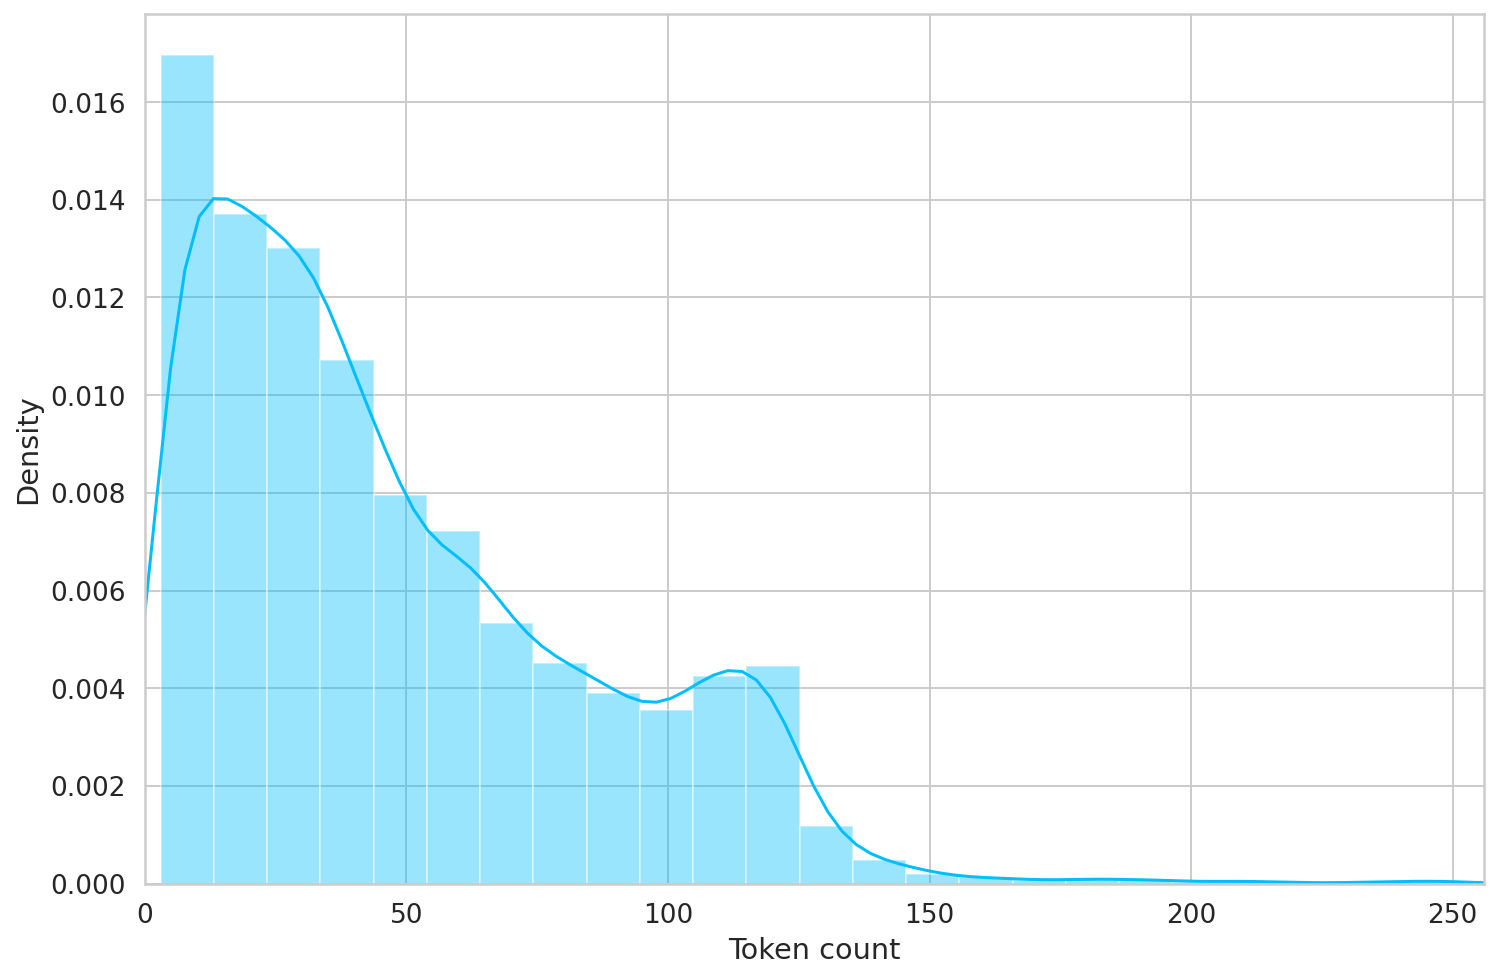

In [40]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

大多數評論似乎包含少於 128 個標記，但我們會安全起見並選擇最大長度為 160。

In [41]:
MAX_LEN = 160

我們擁有創建 PyTorch 數據集所需的所有構建塊。讓我們使用同一個 class ：

In [42]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews         # Reviews is content column.
    self.targets = targets         # Target is the sentiment column.
    self.tokenizer = tokenizer     # Tokenizer is the BERT_Tokanizer.
    self.max_len = max_len         # max_length of each sequence.
  
  def __len__(self):
    return len(self.reviews)       # Len of each review.
  
  def __getitem__(self, item):
    review = str(self.reviews[item])   
    # returns the string of reviews at the index = 'items'
    target = self.targets[item]        
    # returns the string of targets at the index = 'items'

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,                                   
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)            
      # dictionary containing all the features is returned.
    }

 Tokenizer 為我們做了大部分繁重的工作。我們還返回評論文本，因此更容易評估我們模型的預測。接著拆分數據：

### 拆分為訓練集和驗證集

In [43]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [44]:
df_train.shape, df_val.shape, df_test.shape

((13438, 13), (1680, 13), (1680, 13))

### 創建數據加載器以作為我們模型的輸入。下面的函數就是這樣做的。

In [45]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.values,
    targets=df.sentiment.values,
    tokenizer=tokenizer,
    max_len=max_len
  )                                  # Dataset would be created which can be used to create and return dataloader.

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
  )

In [46]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

看一下來自我們的訓練數據加載器的範例：

In [47]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [48]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


## 使用 BERT 和 Hugging Face 進行情感分類

有很多助手可以通過 Transformers 庫輕鬆使用 BERT。根據任務，我們可能會使用“BertForSequenceClassification”、“BertForQuestionAnswering”或其他東西。

我將使用基本的 BertModel 並在其之上構建我們的情感分類器。讓我們加載模型：

In [50]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
model_test = bert_model(
  input_ids=encoding_test['input_ids'], 
  attention_mask=encoding_test['attention_mask']
)
model_test.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

“last_hidden_​​state”是模型最後一層的隱藏狀態序列。獲得“pooled_output”是通過應用 BertPooler 來完成的，它基本上應用了 tanh 函數來匯集所有輸出。

In [52]:
last_hidden_state=model_test['last_hidden_state']
pooled_output=model_test['pooler_output']

In [53]:
last_hidden_state.shape

torch.Size([1, 32, 768])

我們有 32 個 tokens （範例序列的長度）中的每一個的隱藏狀態，768 是前饋網絡中隱藏單元的數量。我們可以通過檢查配置來驗證：

In [54]:
bert_model.config.hidden_size

768

根據 BERT，我們可以將 pooled_output 視為內容的摘要。讓我們看看輸出的形狀：

In [55]:
pooled_output.shape

torch.Size([1, 768])

我們可以使用所有這些知識來創建一個使用 BERT 模型的情感分類器：

In [56]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)                                 
    ## For regularization with dropout probability 0.3.
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) 
    ## append an Output fully connected layer representing the number of classes
  
  def forward(self, input_ids, attention_mask):
    returned = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = returned["pooler_output"]
    output = self.drop(pooled_output)
    return self.out(output)

分類器將大部分工作委託給 BertModel。我們使用 dropout 層進行一些 regularization ，並使用全連接層進行輸出。我們返回最後一層的原始輸出，因為這是 PyTorch 中的 cross-entropy 損失函數工作所必需的。 

接著像任何其他 PyTorch 模型一樣。創建一個實例並將其移動到 GPU：

In [57]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.

我們將使用 dataloader 將上面創建的訓練數據的示例批次移動到 GPU：

In [58]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 160])
torch.Size([8, 160])


為了從我們訓練的模型中獲得預測概率，我們將對從輸出層獲得的輸出應用 softmax 函數：

In [59]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2223, 0.4739, 0.3038],
        [0.2466, 0.2892, 0.4642],
        [0.3648, 0.2353, 0.3999],
        [0.2035, 0.3812, 0.4152],
        [0.5490, 0.2330, 0.2180],
        [0.2370, 0.4316, 0.3313],
        [0.2812, 0.2872, 0.4316],
        [0.3672, 0.2475, 0.3852]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## 訓練模型

為了重現 BERT 論文中的訓練過程，我們將使用 Hugging Face 提供的 AdamW 優化器。它糾正了權重衰減，因此與原始論文相似。我們還將使用沒有 warmup steps 的 linear scheduler ：

In [60]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS    
# Number of batches * Epochs (Required for the scheduler.)
 
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,     # Recommended in the BERT paper.
  num_training_steps=total_steps  
)

loss_fn = nn.CrossEntropyLoss().to(device)

BERT 作者有一些微調的建議：
 - Batch size ：16、32 
 - Learning rate (Adam) ：5e-5、3e-5、2e-5 
 - Number of epochs ：2, 3, 4

### 用於訓練我們的模型一個 epoch 的輔助函數：

In [61]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()    
  # To make sure that the droupout and normalization is enabled during the training.

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    max_prob, preds = torch.max(outputs, dim=1)    
    # Returns 2 tensors, one with max_probability and another with the respective predicted label.
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()     # Back_Propogation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
    # Recommended by the BERT paper to clip the gradients to avoid exploding gradients.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)     
  # Return the mean loss and the ratio of correct predictions.

訓練模型類似於訓練深度神經網絡，但有兩點不同。

每次將批次饋送到模型時都會調用調度程序。我們通過使用 clip_grad_norm 裁剪模型的梯度來避免梯度爆炸

### 在給定數據加載器上評估模型的輔助函數：

In [62]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()        
  # To make sure that the droupout and normalization is disabled during the training.

  losses = []
  correct_predictions = 0

  with torch.no_grad():        
    # Back propogation is not required. Torch would perform faster. 
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_prob, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

使用這兩個輔助函數，我們可以編寫我們的訓練循環。我們還將儲存訓練歷史：

In [63]:
%%time

history = defaultdict(list)          
# Similar to Keras library saves history
best_accuracy = 0                    

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 0.7996609724038058 accuracy 0.6334275933918738
Val   loss 0.6771343524257342 accuracy 0.7196428571428573

Epoch 2/10
----------
Train loss 0.5377607360382431 accuracy 0.7945378776603661
Val   loss 0.6572691420359271 accuracy 0.7589285714285715

Epoch 3/10
----------
Train loss 0.3812009277333605 accuracy 0.8842833755023068
Val   loss 0.8388764296237025 accuracy 0.7886904761904763

Epoch 4/10
----------
Train loss 0.2869755375314742 accuracy 0.9255097484744753
Val   loss 0.9604995209352291 accuracy 0.799404761904762

Epoch 5/10
----------
Train loss 0.21293873480558215 accuracy 0.9490251525524631
Val   loss 1.0633613184465849 accuracy 0.8083333333333335

Epoch 6/10
----------
Train loss 0.16077435581594599 accuracy 0.9611549337699062
Val   loss 1.179326347159804 accuracy 0.8208333333333334

Epoch 7/10
----------
Train loss 0.11881019515795266 accuracy 0.9706801607382051
Val   loss 1.2572496132973658 accuracy 0.8196428571428572

Epoch 8/10
----------
Train loss 0.0900150381286

我們正在儲存最佳模型的狀態，由最高驗證準確度表示。

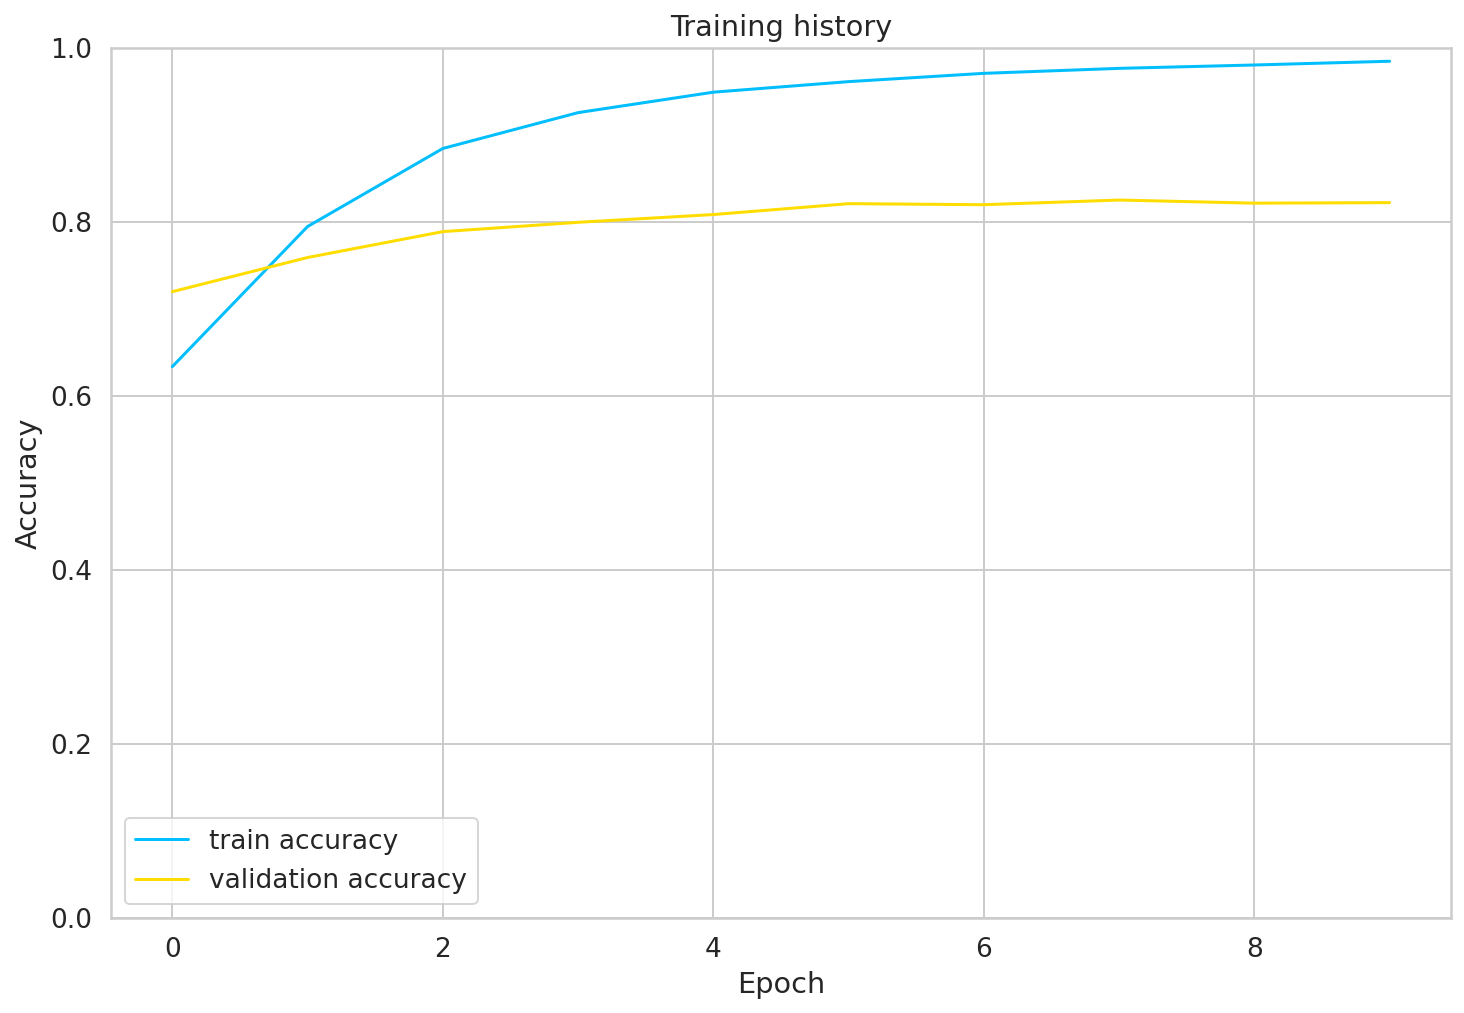

In [64]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 評估

那麼我們的模型預測情緒有多好？讓我們從計算測試數據的準確率開始：

In [65]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.818452380952381

在測試集上的準確率大約低 1%。我們的模型似乎可以很好地概括。 我們將定義一個輔助函數來從我們的模型中獲取預測：

In [66]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

這類似於評估函數，除了我們儲存評論文本和預測概率（通過在模型輸出上應用 softmax）：

In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


分類報告 : 

In [68]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.82      0.84       555
     neutral       0.71      0.79      0.74       505
    positive       0.88      0.85      0.86       620

    accuracy                           0.82      1680
   macro avg       0.82      0.82      0.82      1680
weighted avg       0.82      0.82      0.82      1680



看起來很難對中性（3 星）評論進行分類。

從認知上，那些的確很難歸類。 

接著繼續使用混淆矩陣：

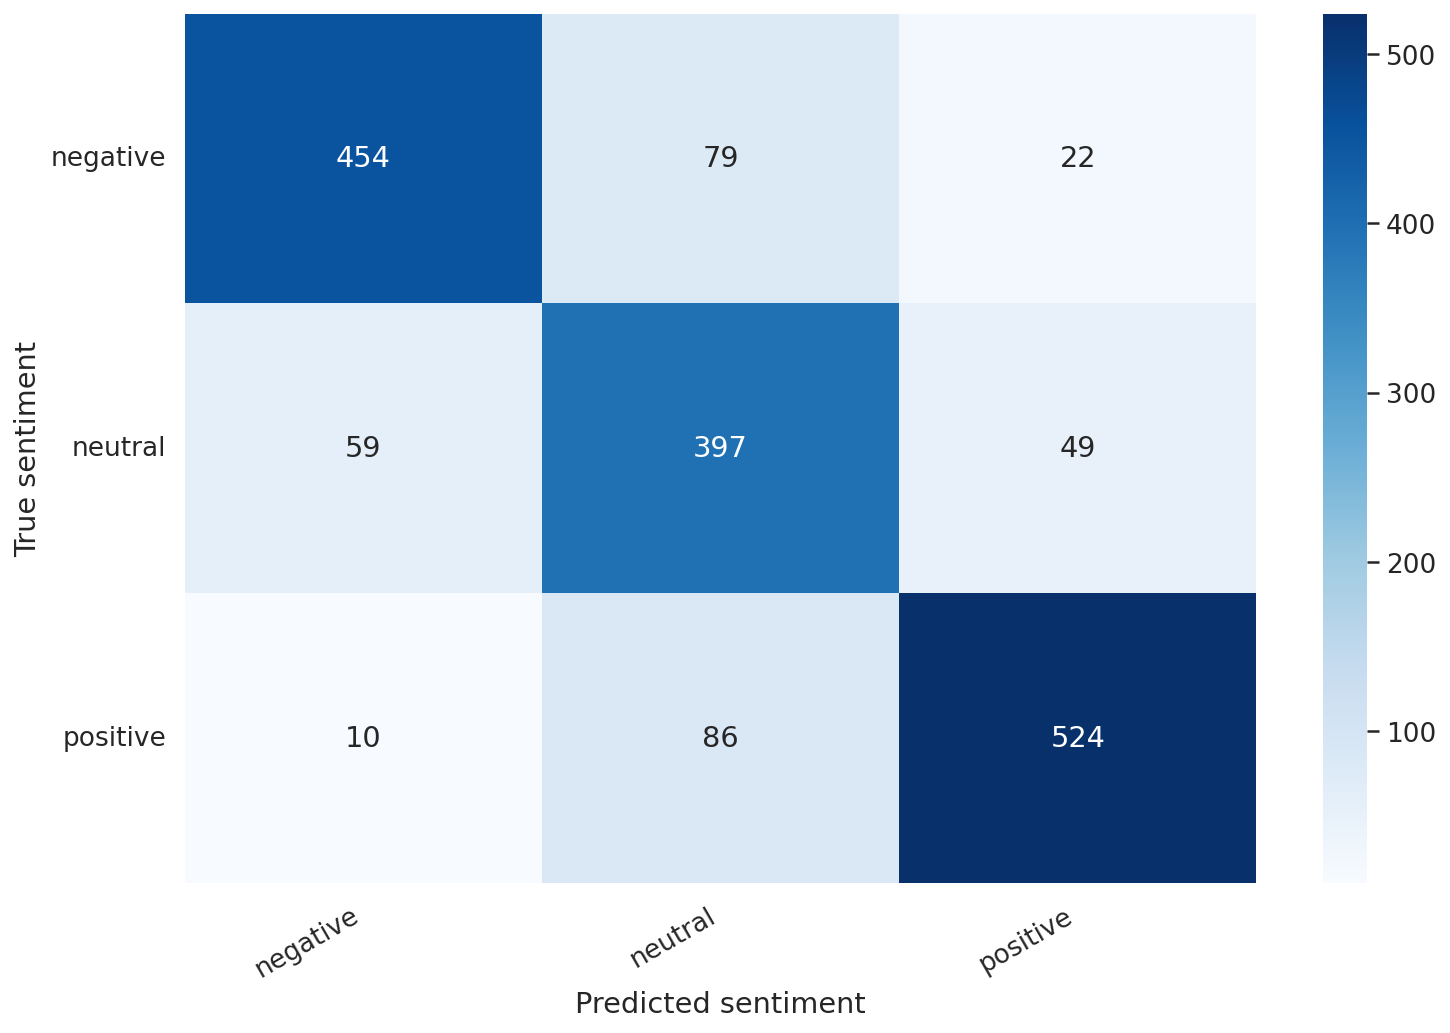

In [69]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

這證實了我們的模型難以對中立評論進行分類。

它以大致相等的頻率將那些誤認為負面和正面。 

這是我們模型性能的一個很好的概述。但讓我們看一下我們測試數據中的一個例子：

In [70]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [71]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

It seems good but there is no way for me to increase the "art"
category. Music and drawing are not the only forms of art. Please
change this. Maybe change art to "crearivity" but certainly add more
creative pursuits so those who cannot draw or do music can increase
it. Also aren't erudition and learning really the same thing? My
conclusion is that this app is great but needs a lit of work.

True sentiment: positive


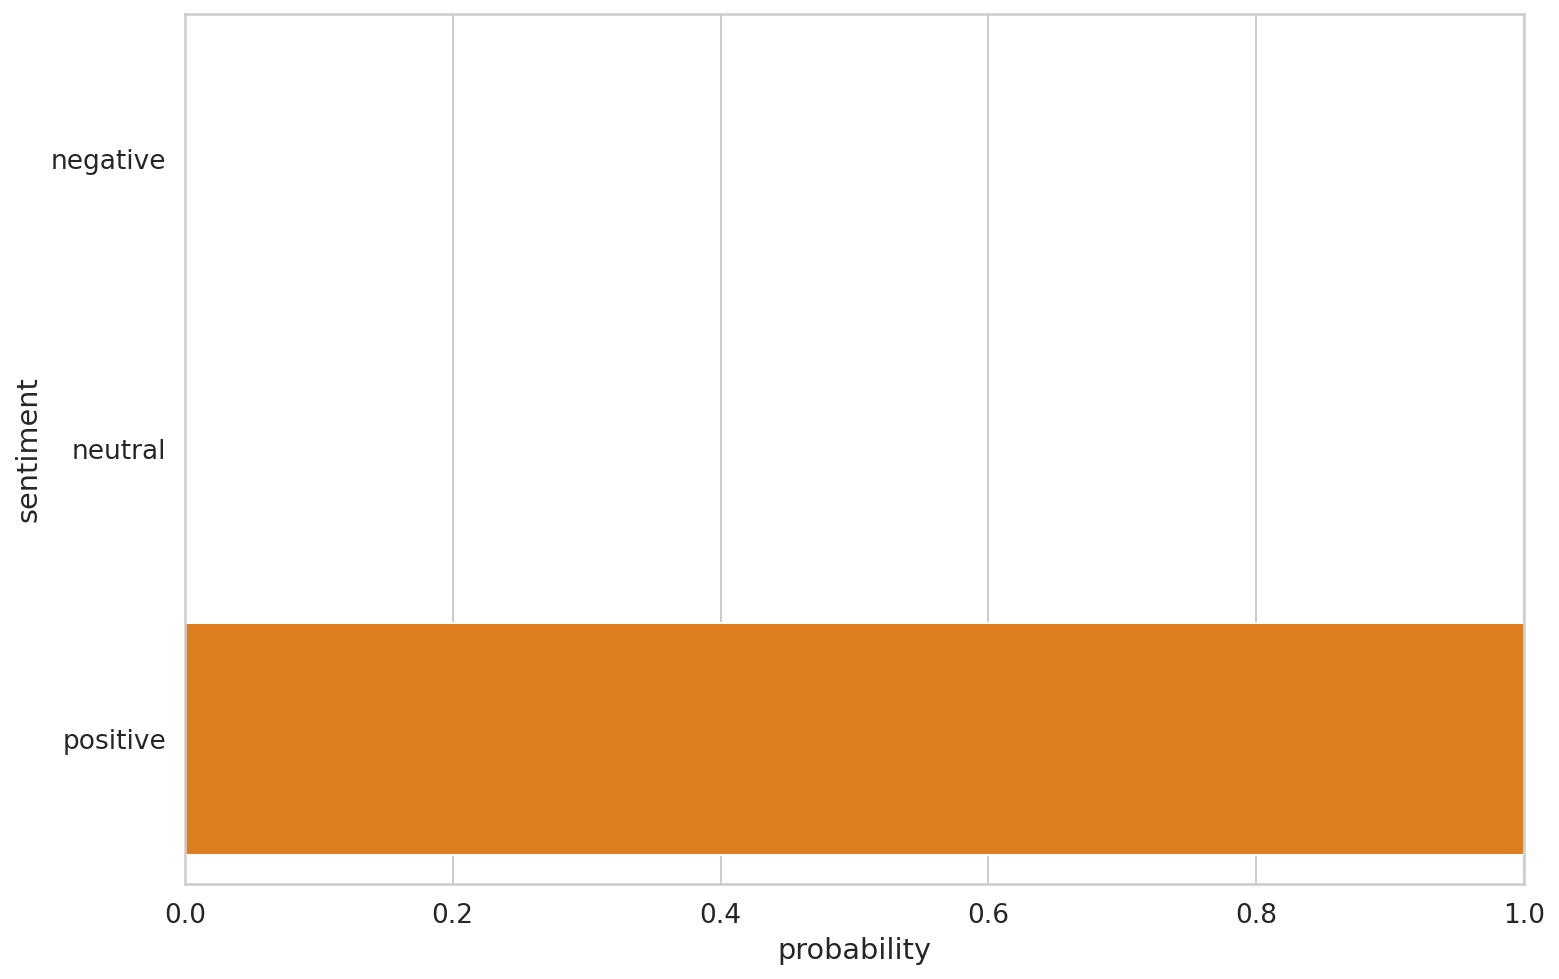

In [72]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## 預測原始文本
讓我們使用我們的模型來預測一些原始文本的情緒：

In [73]:
review_text = "I love completing my todos! Best app ever!!!"

我們必須使用 tokenizer 對文本進行編碼：

In [74]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


讓我們從我們的模型中得到預測：

In [75]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
